# Clustering-based Stock Portfolio
1. [Data preprocessing](#01.-Data-Preprocessing)
2. [Main](#02.-Main)
3. [Analysis](#03.-Analysis)

In [ ]:
from src.preprocessing_utils import *
from src.clustering import *
from src.portfolio import *
from functools import reduce
import pandas as pd
import numpy as np
import seaborn.apionly as sns
import matplotlib.pyplot as plt
import os
import pickle

---

## 01. Data Preprocessing
### `scripts/01_data-preprocessing.R` $\rightarrow$ `scripts/preprocess.py`

### Stock data

In [2]:
path = os.path.join("data", "raw")
file_names = ["asset", "asset-growth", "equity", "equity-turnover",
              "leverage", "market-cap", "net-profit", "pcr", "per",
              "stock-number", "stock-price", "trade-amount", "volatility"]
var_names = ["asset", "asset_growth", "equity", "equity_turnover",
             "leverage", "market_cap", "net_profit", "pcr", "per",
             "stock_num", "price", "trade_amount", "volatility"]
extension = ".xls"

In [3]:
stock_tbl = preprocess(path, file_names, var_names, extension=".xls")
stock_tbl.head()

asset, asset-growth, equity, equity-turnover, leverage, market-cap, net-profit, pcr, per, stock-number, stock-price, trade-amount, volatility, 

,code,time,leverage,asset_growth,shares_turnover,roa,roe,size,pcr,per,equity_turnover,volatility,logret
0,000020,1997-1,NaN,NaN,0.006314,NaN,NaN,8.850400e+10,NaN,15.586667,NaN,60.255281,NaN
1,000020,1997-2,206.92,23.60,0.015739,0.002507,0.007696,1.104880e+11,NaN,11.053333,2.22,62.004616,0.235505
2,000020,1997-3,NaN,NaN,0.004035,NaN,NaN,1.087867e+11,NaN,10.543333,NaN,56.334550,-0.040738
3,000020,1997-4,324.23,12.41,0.004633,0.009214,0.039088,4.613333e+10,NaN,4.346667,2.89,62.702979,-0.847219
4,000020,1998-1,NaN,NaN,0.012191,NaN,NaN,5.973333e+10,NaN,4.750000,NaN,73.726084,0.120535


### KOSPI index

In [4]:
def unpack_df(df):
    df = df.reset_index()
    df["time"] = df[['time', 'level_1']].astype(str).apply(lambda x: '-'.join(x), axis=1)
    df = pd.concat([df.time, df.price], axis=1)
    df.columns = ["time", "logret"]
    return df

In [14]:
kospi = pd.read_excel("data/raw/kospi-index.xlsx", names=["time", "price"])
g = kospi.groupby([pd.DatetimeIndex(kospi.time).year, as_quarter(pd.DatetimeIndex(kospi.time).month)])
g = np.log(g.mean()).diff()
kospi = unpack_df(g)
kospi.head()

,time,logret
0,1997-1,NaN
1,1997-2,0.082477
2,1997-3,-0.064037
3,1997-4,-0.499768
4,1998-1,0.247514


### Risk-free rate

In [10]:
risk_free = pd.read_excel("data/raw/cd-risk-free.xlsx", names=["time", "r"])
risk_free.time = risk_free.time.str.replace("/", "-").str.split().str[0]
risk_free.r = np.log(1 + risk_free.r / 100)
risk_free.head()

,time,r
0,1997-1,0.119707
1,1997-2,0.118287
2,1997-3,0.119115
3,1997-4,0.145110
4,1998-1,0.204599


### Save processed data

In [11]:
stock_tbl.to_csv("data/processed/stock2.csv", index=False)
kospi.to_csv("data/processed/kospi2.csv", index=False)
risk_free.to_csv("data/processed/risk_free2.csv", index=False)

---

## 02. Main
### `scripts/02_main.R` $\rightarrow$ `scripts/main.py`

### Random state

In [51]:
random_state = 0

### Load data

In [52]:
stock_tbl = pd.read_csv("data/processed/stock.csv")
kospi = pd.read_csv("data/processed/kospi.csv")
risk_free = pd.read_csv("data/processed/risk_free.csv")

### Models

In [53]:
with_list = [
    "return", 
    "market_residual", 
    "factors", 
    "factors_residual"
]
n_time_list = [
    6, 8, 
    10, 12
]
method_list = [
    "GMV", "Tangency"
]

### Validation period

In [54]:
start_list = ["2002-4", "2005-4", "2008-4", "2011-4"]
end_list = ["2005-3", "2008-3", "2011-3", "2014-3"]
valid_res = []

for st, en in zip(start_list, end_list):
    valid_res.append(evaluate_portfolio(stock_tbl, kospi, risk_free, st, en,
                                        with_list, n_time_list, method_list, 
                                        random_state=random_state))

from 2002-4 to 2005-3
  with: return
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.91s/it]


  with: return
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.90s/it]


  with: return
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.50s/it]


  with: return
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:29<00:00,  2.48s/it]


  with: return
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:38<00:00,  3.12s/it]


  with: return
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:37<00:00,  3.13s/it]


  with: return
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:45<00:00,  3.86s/it]


  with: return
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:44<00:00,  3.72s/it]


  with: market_residual
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:17<00:00,  6.56s/it]


  with: market_residual
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:27<00:00,  7.51s/it]


  with: market_residual
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:35<00:00,  7.20s/it]


  with: market_residual
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:25<00:00,  7.11s/it]


  with: market_residual
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:32<00:00,  7.88s/it]


  with: market_residual
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:32<00:00,  7.72s/it]


  with: market_residual
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:41<00:00,  8.46s/it]


  with: market_residual
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:40<00:00,  8.39s/it]


  with: factors
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:10<00:00,  1.10it/s]


  with: factors
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:10<00:00,  1.11it/s]


  with: factors
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.14s/it]


  with: factors
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.15s/it]


  with: factors
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.48s/it]


  with: factors
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.42s/it]


  with: factors
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:20<00:00,  1.77s/it]


  with: factors
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:20<00:00,  1.76s/it]


  with: factors_residual
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:46<00:00,  8.82s/it]


  with: factors_residual
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:46<00:00,  8.87s/it]


  with: factors_residual
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:54<00:00,  9.57s/it]


  with: factors_residual
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:55<00:00,  9.59s/it]


  with: factors_residual
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:03<00:00, 10.32s/it]


  with: factors_residual
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:03<00:00, 10.31s/it]


  with: factors_residual
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:11<00:00, 10.97s/it]


  with: factors_residual
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:14<00:00, 11.87s/it]


from 2005-4 to 2008-3
  with: return
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:25<00:00,  2.12s/it]


  with: return
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:24<00:00,  2.05s/it]


  with: return
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:33<00:00,  2.72s/it]


  with: return
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:32<00:00,  2.72s/it]


  with: return
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:40<00:00,  3.40s/it]


  with: return
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:41<00:00,  3.48s/it]


  with: return
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.11s/it]


  with: return
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.13s/it]


  with: market_residual
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:23<00:00,  6.89s/it]


  with: market_residual
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:23<00:00,  6.92s/it]


  with: market_residual
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:31<00:00,  7.72s/it]


  with: market_residual
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:30<00:00,  7.56s/it]


  with: market_residual
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:40<00:00,  8.33s/it]


  with: market_residual
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:40<00:00,  8.30s/it]


  with: market_residual
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:48<00:00,  9.05s/it]


  with: market_residual
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:48<00:00,  9.06s/it]


  with: factors
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:12<00:00,  1.08s/it]


  with: factors
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:12<00:00,  1.07s/it]


  with: factors
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.34s/it]


  with: factors
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.35s/it]


  with: factors
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:19<00:00,  1.64s/it]


  with: factors
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:20<00:00,  1.64s/it]


  with: factors
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.94s/it]


  with: factors
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it]


  with: factors_residual
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:46<00:00,  8.82s/it]


  with: factors_residual
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:46<00:00,  8.86s/it]


  with: factors_residual
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:54<00:00,  9.58s/it]


  with: factors_residual
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:55<00:00,  9.61s/it]


  with: factors_residual
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:03<00:00, 10.32s/it]


  with: factors_residual
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:03<00:00, 10.28s/it]


  with: factors_residual
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:12<00:00, 10.99s/it]


  with: factors_residual
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:12<00:00, 11.02s/it]


from 2008-4 to 2011-3
  with: return
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:24<00:00,  2.05s/it]


  with: return
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:24<00:00,  2.09s/it]


  with: return
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:33<00:00,  2.75s/it]


  with: return
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:32<00:00,  2.73s/it]


  with: return
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:41<00:00,  3.41s/it]


  with: return
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:41<00:00,  3.46s/it]


  with: return
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:48<00:00,  4.08s/it]


  with: return
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.11s/it]


  with: market_residual
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:23<00:00,  6.95s/it]


  with: market_residual
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:23<00:00,  6.95s/it]


  with: market_residual
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:32<00:00,  7.72s/it]


  with: market_residual
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:31<00:00,  7.63s/it]


  with: market_residual
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:40<00:00,  8.35s/it]


  with: market_residual
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:41<00:00,  8.47s/it]


  with: market_residual
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:49<00:00,  9.10s/it]


  with: market_residual
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:49<00:00,  9.06s/it]


  with: factors
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.14s/it]


  with: factors
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:12<00:00,  1.12s/it]


  with: factors
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.42s/it]


  with: factors
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.41s/it]


  with: factors
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:20<00:00,  1.80s/it]


  with: factors
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:20<00:00,  1.72s/it]


  with: factors
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  2.01s/it]


  with: factors
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  2.00s/it]


  with: factors_residual
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:46<00:00,  8.84s/it]


  with: factors_residual
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:46<00:00,  8.89s/it]


  with: factors_residual
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:59<00:00,  9.68s/it]


  with: factors_residual
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:55<00:00,  9.62s/it]


  with: factors_residual
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:04<00:00, 10.30s/it]


  with: factors_residual
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:03<00:00, 10.31s/it]


  with: factors_residual
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:12<00:00, 10.99s/it]


  with: factors_residual
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:12<00:00, 10.99s/it]
C:\Users\user\Desktop\clustering-based-stock-portfolio\src\portfolio.py:96: RuntimeWarning: invalid value encountered in sqrt
  pr_sd = np.diag(np.sqrt(pr_tbl.iloc[:, 2:].cov()))


from 2011-4 to 2014-3
  with: return
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:25<00:00,  2.10s/it]


  with: return
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:26<00:00,  2.21s/it]


  with: return
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:33<00:00,  2.79s/it]


  with: return
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:33<00:00,  2.78s/it]


  with: return
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:41<00:00,  3.48s/it]


  with: return
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:43<00:00,  3.51s/it]


  with: return
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.12s/it]


  with: return
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:50<00:00,  4.19s/it]


  with: market_residual
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:23<00:00,  6.97s/it]


  with: market_residual
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:25<00:00,  7.04s/it]


  with: market_residual
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:32<00:00,  7.72s/it]


  with: market_residual
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:33<00:00,  7.87s/it]


  with: market_residual
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:40<00:00,  8.38s/it]


  with: market_residual
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:41<00:00,  8.41s/it]


  with: market_residual
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:52<00:00,  9.20s/it]


  with: market_residual
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:50<00:00,  9.15s/it]


  with: factors
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:14<00:00,  1.19s/it]


  with: factors
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:14<00:00,  1.20s/it]


  with: factors
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:19<00:00,  1.61s/it]


  with: factors
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:18<00:00,  1.55s/it]


  with: factors
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.90s/it]


  with: factors
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.89s/it]


  with: factors
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:26<00:00,  2.26s/it]


  with: factors
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:27<00:00,  2.37s/it]


  with: factors_residual
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:46<00:00,  8.90s/it]


  with: factors_residual
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:48<00:00,  8.88s/it]


  with: factors_residual
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:55<00:00,  9.56s/it]


  with: factors_residual
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:55<00:00,  9.55s/it]


  with: factors_residual
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:03<00:00, 10.27s/it]


  with: factors_residual
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:04<00:00, 10.28s/it]


  with: factors_residual
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:12<00:00, 11.01s/it]


  with: factors_residual
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:13<00:00, 11.22s/it]
C:\Users\user\Desktop\clustering-based-stock-portfolio\src\portfolio.py:96: RuntimeWarning: invalid value encountered in sqrt
  pr_sd = np.diag(np.sqrt(pr_tbl.iloc[:, 2:].cov()))


In [9]:
valid_res[0]["return"].head()

,time,kospi,market_residual_6_GMV,market_residual_8_GMV
0,2002-4,-0.043557,-0.182029,-0.168141
1,2003-1,-0.166381,0.150088,0.133076
2,2003-2,0.110888,0.033397,0.123056
3,2003-3,0.131688,0.120947,0.070731
4,2003-4,0.096017,0.013463,0.015975


In [11]:
valid_res[0]["summary"]

,with,n_time,method,cumsum,sd,info_r
market_residual_6_GMV,market_residual,6,GMV,0.683359,0.095750,0.127044
market_residual_8_GMV,market_residual,8,GMV,0.496945,0.098431,0.006877


### Test period

In [55]:
start = "2014-4"
end = "2017-3"

test_res = evaluate_portfolio(stock_tbl, kospi, risk_free, start, end,
                              with_list, n_time_list, method_list)

from 2014-4 to 2017-3
  with: return
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:25<00:00,  2.13s/it]


  with: return
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:26<00:00,  2.19s/it]


  with: return
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:33<00:00,  2.80s/it]


  with: return
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:34<00:00,  2.99s/it]


  with: return
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:41<00:00,  3.47s/it]


  with: return
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:41<00:00,  3.44s/it]


  with: return
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:50<00:00,  4.24s/it]


  with: return
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.16s/it]


  with: market_residual
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:24<00:00,  7.03s/it]


  with: market_residual
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:23<00:00,  6.96s/it]


  with: market_residual
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:33<00:00,  7.70s/it]


  with: market_residual
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:36<00:00,  8.39s/it]


  with: market_residual
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:41<00:00,  8.45s/it]


  with: market_residual
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:41<00:00,  8.49s/it]


  with: market_residual
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:50<00:00,  9.26s/it]


  with: market_residual
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:50<00:00,  9.32s/it]


  with: factors
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.34s/it]


  with: factors
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.35s/it]


  with: factors
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:19<00:00,  1.71s/it]


  with: factors
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:19<00:00,  1.72s/it]


  with: factors
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:24<00:00,  2.10s/it]


  with: factors
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:25<00:00,  2.14s/it]


  with: factors
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:28<00:00,  2.48s/it]


  with: factors
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:28<00:00,  2.48s/it]


  with: factors_residual
  n_time: 6
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:47<00:00,  8.90s/it]


  with: factors_residual
  n_time: 6
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:46<00:00,  8.90s/it]


  with: factors_residual
  n_time: 8
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:55<00:00,  9.68s/it]


  with: factors_residual
  n_time: 8
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:55<00:00,  9.68s/it]


  with: factors_residual
  n_time: 10
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:05<00:00, 10.76s/it]


  with: factors_residual
  n_time: 10
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:05<00:00, 10.38s/it]


  with: factors_residual
  n_time: 12
  method: GMV


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:16<00:00, 11.57s/it]


  with: factors_residual
  n_time: 12
  method: Tangency


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:13<00:00, 11.05s/it]
C:\Users\user\Desktop\clustering-based-stock-portfolio\src\portfolio.py:96: RuntimeWarning: invalid value encountered in sqrt
  pr_sd = np.diag(np.sqrt(pr_tbl.iloc[:, 2:].cov()))


### Save results

In [56]:
import os
import pickle

In [57]:
try:
    os.mkdir("outputs")
except OSError:
    print("outputs directory already exists")

outputs directory already exists


In [58]:
with open("outputs/valid_res_list.pickle", "wb") as wb:
    pickle.dump(valid_res, wb)
with open("outputs/test_res.pickle", "wb") as wb:
    pickle.dump(test_res, wb)

In [59]:
import datetime
datetime.datetime.now()

datetime.datetime(2019, 5, 22, 21, 1, 12, 977914)

---

## 03. Analysis
### `scripts/03_analysis.R` $\rightarrow$ `scripts/analysis.py`

In [61]:
with open("outputs/valid_res_list.pickle", "rb") as rb:
    valid_res = pickle.load(rb)
with open("outputs/test_res.pickle", "rb") as rb:
    test_res = pickle.load(rb)

In [62]:
kospi = pd.read_csv("data/processed/kospi.csv")

In [63]:
kospi.head()

,time,logret
0,1997-1,NaN
1,1997-2,0.078101
2,1997-3,-0.064037
3,1997-4,-0.499768
4,1998-1,0.247514


### Summary of `["result"]`

In [64]:
def select_model(valid_res_return):
    valid_res_return = valid_res_return.loc[:, ["time", "kospi", "factors_8_GMV", "factors_8_Tangency"]]
    valid_res_return.columns = ["time", "kospi", "GMV", "Tangency"]
    return valid_res_return

In [65]:
def summarize_sd(selected):
    return selected.std()

**1) Summary of validation results**

In [101]:
sd_summ = None
for i in range(len(valid_res)):
    newline = select_model(valid_res[i]["return"]).std()
    sd_summ = pd.concat([sd_summ, newline], axis=1) if sd_summ is not None else newline
sd_summ = sd_summ.T

In [102]:
sd_summ

,kospi,GMV,Tangency
0,0.100272,0.100403,0.124856
1,0.104019,0.113553,0.152245
0,0.127488,0.071997,0.074054
0,0.036766,0.046499,0.238077


In [103]:
sd_summ.to_csv("outputs/sd_summ2.csv", index=False)

**2) Summary of test result**

In [108]:
summarize_sd(select_model(test_res["return"]))

kospi       0.044938
GMV         0.045417
Tangency    0.063051
dtype: float64

### Summary of `["summary"]`

In [148]:
def method_avg(x):
    n = x.shape[0]
    y = pd.DataFrame(x.loc[:, ["cumsum", "sd", "info_r"]] \
                      .to_numpy() \
                      .reshape(2, -1, order="F") \
                      .mean(axis=0) \
                      .reshape(n//2, -1, order="F") \
                      .round(3))
    y.columns = ["cumsum", "sd", "info_r"]
    
    return pd.concat([x.loc[:, ["with", "n_time"]] \
                       .drop_duplicates() \
                       .reset_index(drop=True), y], axis=1)

**1) Summary of validation results**

In [154]:
from functools import reduce

In [194]:
summ_list = np.dstack(map(lambda x: x["summary"].loc[:, ["cumsum", "sd", "info_r"]] \
                                                .to_numpy(), valid_res)).sum(axis=2)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [198]:
summ_list = summ_list / len(valid_res)
summ_list = pd.DataFrame(summ_list, columns=["cumsum", "sd", "info_r"])

In [213]:
valid_summ = method_avg(pd.concat([valid_res[0]["summary"].loc[:, ["with", "n_time", "method"]].reset_index(drop=True), summ_list], axis=1))
valid_summ["rank"] = np.argsort(-valid_summ.info_r) + 1

In [214]:
valid_summ

,with,n_time,cumsum,sd,info_r,rank
0,factors,6,0.100,0.027,0.024,10
1,factors,8,0.096,0.029,0.016,1
2,factors,10,0.000,0.038,-0.011,6
3,factors,12,0.069,0.024,0.002,14
4,factors_residual,6,0.098,0.027,0.021,5
5,factors_residual,8,0.110,0.029,0.024,9
6,factors_residual,10,0.036,0.035,0.002,2
7,factors_residual,12,0.073,0.024,0.005,11
8,market_residual,6,0.092,0.022,0.019,12
9,market_residual,8,0.101,0.022,0.026,13


**2) Summary of test result**

In [215]:
test_summ = method_avg(test_res["summary"])
test_summ["rank"] = np.argsort(-test_summ.info_r) + 1

In [216]:
test_summ

,with,n_time,cumsum,sd,info_r,rank
0,factors,6,0.179,0.052,0.037,12
1,factors,8,0.109,0.054,-0.055,11
2,factors,10,0.178,0.054,0.043,10
3,factors,12,0.132,0.050,-0.026,14
4,factors_residual,6,0.223,0.054,0.094,9
5,factors_residual,8,0.171,0.059,0.032,13
6,factors_residual,10,0.128,0.047,-0.038,15
7,factors_residual,12,0.127,0.050,-0.030,5
8,market_residual,6,0.279,0.051,0.148,3
9,market_residual,8,0.387,0.055,0.251,1


### Validation plot

In [280]:
import seaborn.apionly as sns
import matplotlib.pyplot as plt

In [313]:
def cumret_plot(model):
    model = pd.melt(model, id_vars=['time'], value_vars=['kospi', "GMV", "Tangency"])
    model.columns = ["time", "asset", "logret"]
    model["asset"] = model.asset.astype("category")
    for a in model.asset.unique():
        model.loc[model.asset == a, "cumret"] = model.loc[model.asset == a, "logret"].cumsum().to_numpy()
        #model.loc[model.asset == a, "cumret_lin"] = np.exp(model.loc[model.asset == a, "cumret"].to_numpy())
    
    fig = plt.figure(figsize=(12,6))
    ax = sns.lineplot(x="time", y="cumret", hue="asset",
                      marker="+", mec=None, dashes=False, data=model)
    ax.xaxis.set_tick_params(rotation=90)
    
    plt.xlabel("Time", size=16)
    plt.ylabel("Cumulative return", size=16)
    plt.grid()
    plt.tight_layout()
    
    return fig, ax

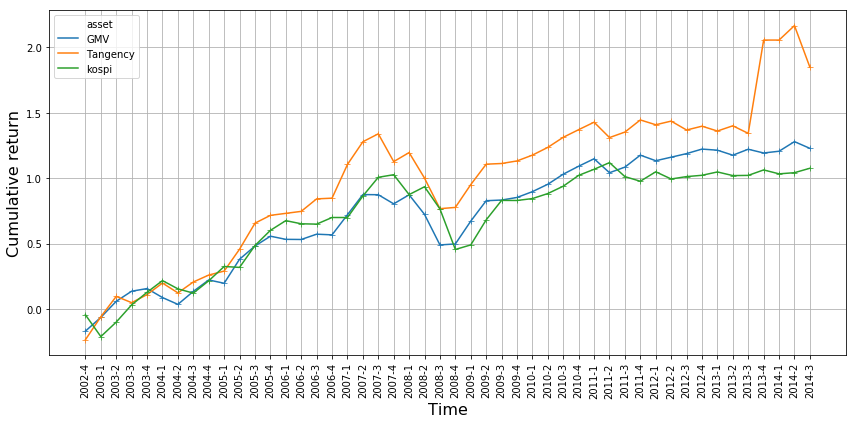

In [314]:
model = select_model(pd.concat([v["return"] for v in valid_res]).reset_index(drop=True))
valid_cumret_total_plot = cumret_plot(model)

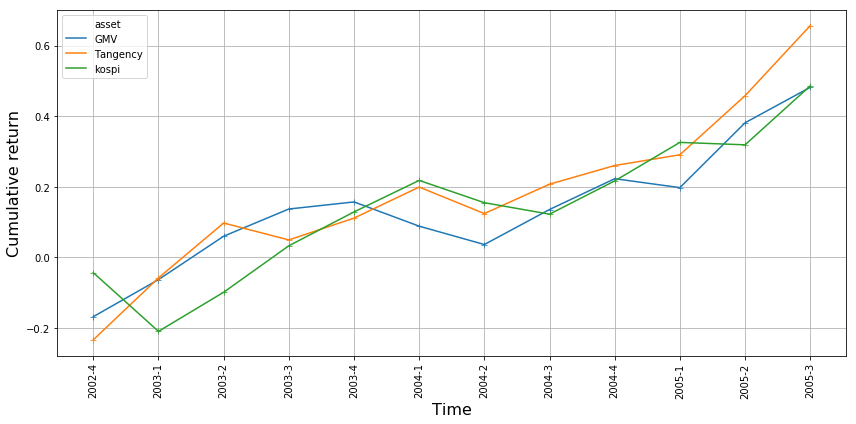

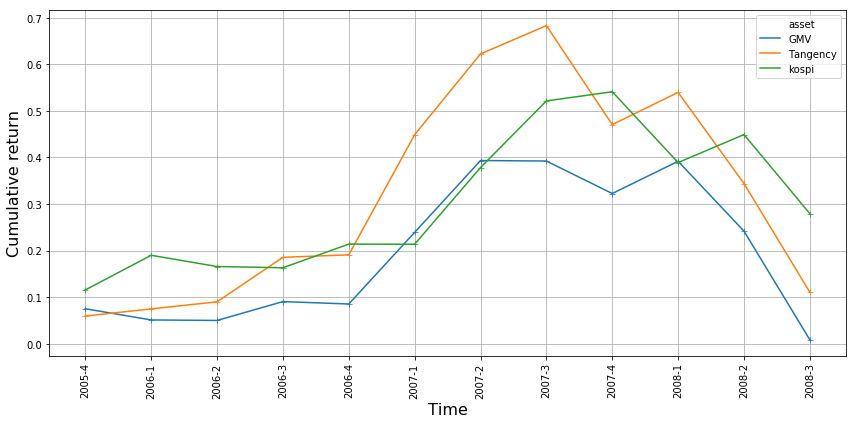

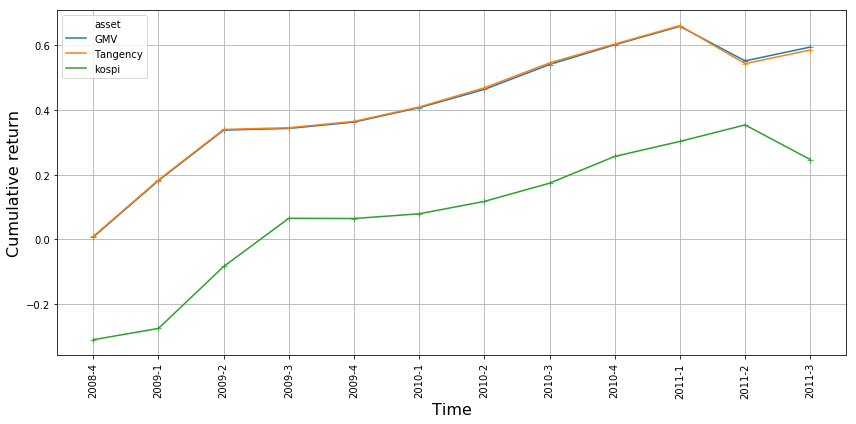

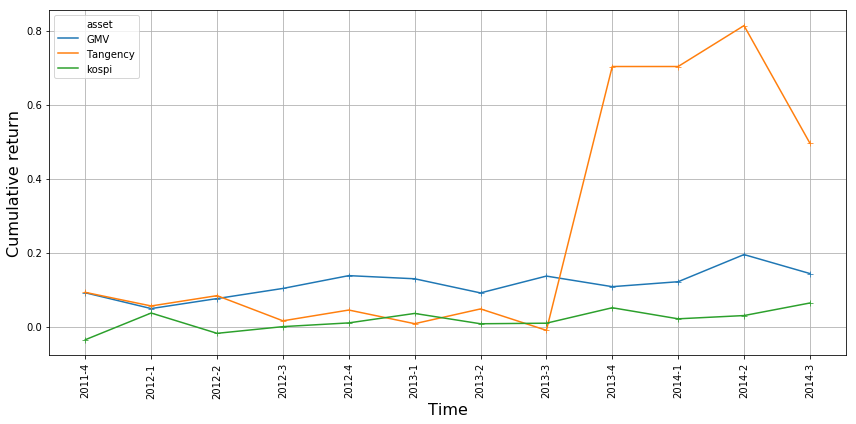

In [315]:
valid_cumret_part_plot = [cumret_plot(select_model(v["return"])) for v in valid_res]

**Save figures**

In [316]:
valid_cumret_total_plot[0].savefig("outputs/valid_plot_00(2).png")
[fig.savefig(f"outputs/valid_plot_0{idx+1}(2).png") for idx, (fig, ax) in enumerate(valid_cumret_part_plot)]

print("figures saved")

figures saved


### Test plot

In [317]:
test_ret = test_res["return"].loc[:, ["time", "kospi", "factors_8_GMV", "factors_8_Tangency"]]
test_ret.columns = ["time", "kospi", "GMV", "Tangency"]
test_ret.iloc[:, 1:] = test_ret.iloc[:, 1:].cumsum()

In [318]:
test_ret

,time,kospi,GMV,Tangency
0,2014-4,-0.050561,0.029067,0.017840
1,2015-1,-0.031081,0.057541,0.118789
2,2015-2,0.024265,-0.021340,0.167135
3,2015-3,-0.038072,0.005758,0.101273
4,2015-4,-0.029967,-0.015840,0.086028
5,2016-1,-0.056762,0.016858,0.064041
6,2016-2,-0.035809,0.046115,0.013034
7,2016-3,-0.011466,0.037461,-0.094428
8,2016-4,-0.024071,0.095484,-0.092357
9,2017-1,0.024783,0.188314,0.007016


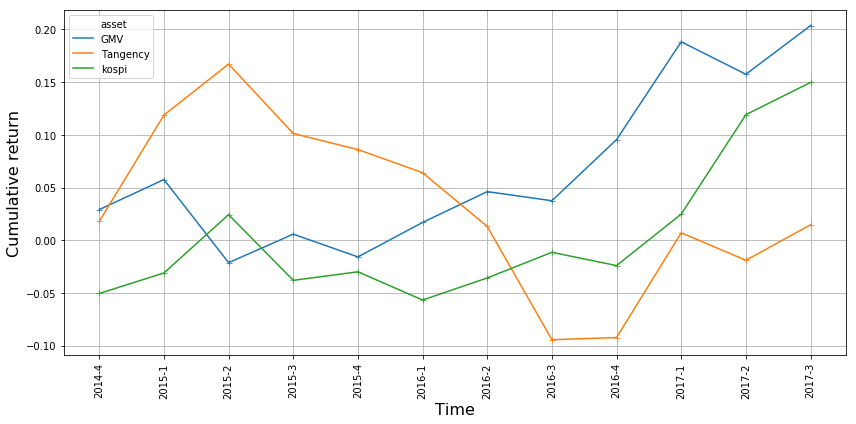

In [319]:
test_cumret_plot = cumret_plot(select_model(test_res["return"]))

**Save figures**

In [320]:
test_cumret_plot[0].savefig("outputs/test-plot(2).png")